# Lecture 8: Fine-tuning for Classification

Lecture 8 | CMU ANLP Spring 2026 | Instructor: Sean Welleck


This notebook shows fine-tuning a language model with a classification head. 

Task: Given a name, predict how many vowels (a, e, i, o, u) it contains.

In [1]:
data = open('names.txt').read().splitlines()
print(f"Total names: {len(data)}")
data[1000:1010]

Total names: 32033


['paityn',
 'evalyn',
 'luz',
 'nathalia',
 'winnie',
 'chandler',
 'ciara',
 'danica',
 'nailah',
 'rilynn']

## Count vowels in names

In [2]:
def count_vowels(name):
    """Count the number of vowels in a name."""
    vowels = 'aeiou'
    return sum(1 for char in name.lower() if char in vowels)

# Test the function
test_names = ['emma', 'olivia', 'charlotte', 'xyz', 'aaa']
for name in test_names:
    print(f"{name}: {count_vowels(name)} vowels")

emma: 2 vowels
olivia: 4 vowels
charlotte: 3 vowels
xyz: 0 vowels
aaa: 3 vowels


## Load the base model and tokenizer

In [3]:
import transformers
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "HuggingFaceTB/SmolLM2-135M"

tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)

# Add special tokens
tokenizer.add_special_tokens({
    "pad_token": "<|pad|>",
    "bos_token": "<|startoftext|>",
})

# Resize embeddings
base_model.resize_token_embeddings(len(tokenizer))

print(f"Model parameters: {sum(p.numel() for p in base_model.parameters()):,}")

/opt/miniconda3/envs/anlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model parameters: 134,516,160


## Create dataset and dataloaders

In [4]:
from torch.utils.data import Dataset, DataLoader
import random

class VowelCountDataset(Dataset):
    def __init__(self, names, tokenizer, max_length=32):
        self.names = names
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = [min(count_vowels(name), 10) for name in names]  # Cap at 10
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        name = self.names[idx]
        label = self.labels[idx]
        
        # Tokenize the name
        text = self.tokenizer.bos_token + name + self.tokenizer.eos_token
        
        return {
            'text': text,
            'label': label,
            'name': name  # For debugging
        }
    
    def collate_fn(self, batch):
        texts = [item['text'] for item in batch]
        labels = torch.tensor([item['label'] for item in batch])
        
        # Tokenize and pad
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': labels
        }

# Split data
random.seed(123)
random.shuffle(data)

n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))

train_data = data[:n1]
dev_data = data[n1:n2]
test_data = data[n2:]

print(f"Train: {len(train_data)}, Dev: {len(dev_data)}, Test: {len(test_data)}")

# Create datasets
train_dataset = VowelCountDataset(train_data, tokenizer)
dev_dataset = VowelCountDataset(dev_data, tokenizer)
test_dataset = VowelCountDataset(test_data, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset.collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=dev_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset.collate_fn)

next(train_loader.__iter__())

Train: 25626, Dev: 3203, Test: 3204


{'input_ids': tensor([[49153, 44450,  1299,   337,     0, 49152],
         [49153,   257,   101,  1241,     0, 49152],
         [49153, 16427,   382,  5488,     0, 49152],
         [49153,  1140,    81,     0, 49152, 49152],
         [49153, 25616,   272,  1744,    94,     0],
         [49153,  2432,  1437,     0, 49152, 49152],
         [49153,  2292,    92,  1287,     0, 49152],
         [49153,  7483,   903,     0, 49152, 49152],
         [49153,    91,   576,   105,     0, 49152],
         [49153,    83,  3231,     0, 49152, 49152],
         [49153,    84,  1437, 18133,     0, 49152],
         [49153,   105,   336,     0, 49152, 49152],
         [49153,   322,  2889,   317,     0, 49152],
         [49153,   106,  1951,  1905,    81,     0],
         [49153,   344,  2554, 37602,     0, 49152],
         [49153, 22258,  1437,     0, 49152, 49152],
         [49153,    86,  9809,     0, 49152, 49152],
         [49153,    99,  1287,   272,   519,     0],
         [49153,   432,   672,  2

## Examine the label distribution

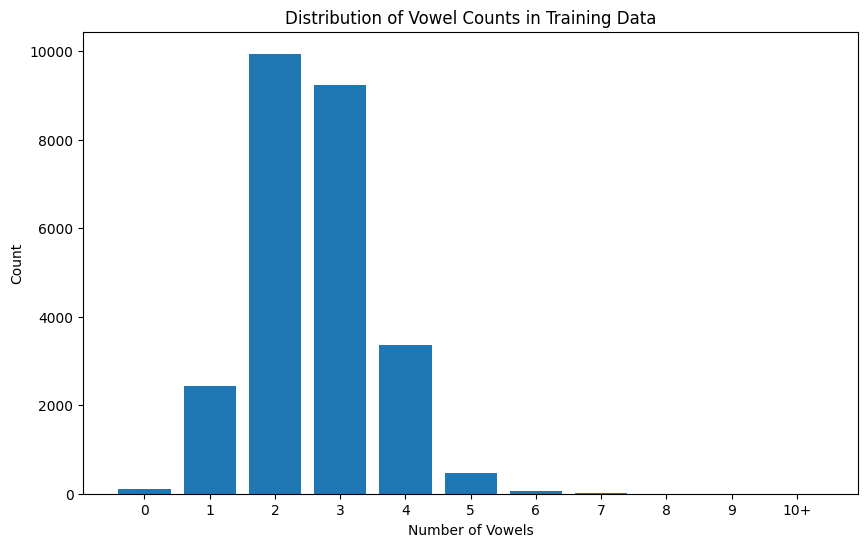

Vowels 0: 96 names (0.4%)
Vowels 1: 2435 names (9.5%)
Vowels 2: 9942 names (38.8%)
Vowels 3: 9238 names (36.0%)
Vowels 4: 3360 names (13.1%)
Vowels 5: 474 names (1.8%)
Vowels 6: 61 names (0.2%)
Vowels 7: 19 names (0.1%)
Vowels 8: 1 names (0.0%)
Vowels 9: 0 names (0.0%)
Vowels 10+: 0 names (0.0%)


In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Count label distribution in training data
train_labels = [min(count_vowels(name), 10) for name in train_data]
label_counts = Counter(train_labels)

# Plot distribution
plt.figure(figsize=(10, 6))
labels = list(range(11))
counts = [label_counts.get(i, 0) for i in labels]
plt.bar(labels, counts)
plt.xlabel('Number of Vowels')
plt.ylabel('Count')
plt.title('Distribution of Vowel Counts in Training Data')
plt.xticks(labels, [str(i) if i < 10 else '10+' for i in labels])
plt.show()

for i in range(11):
    count = label_counts.get(i, 0)
    print(f"Vowels {i if i < 10 else '10+'}: {count} names ({count/len(train_data)*100:.1f}%)")

### LM with a classifier head

In [ ]:
class LMClassifier(nn.Module):
    def __init__(self, base_model, num_classes=11):
        super().__init__()
        self.base_model = base_model
        self.num_classes = num_classes
        self.hidden_size = base_model.config.hidden_size
        self.classifier = nn.Linear(self.hidden_size,  num_classes)

    def _last_token_hidden(self, hidden_states, attention_mask):
        # Find the position of the last non-padding token
        if attention_mask is not None:
            seq_lengths = attention_mask.sum(dim=1) - 1
            batch_size = hidden_states.size(0)
            last_hidden = hidden_states[torch.arange(batch_size), seq_lengths]
        else:
            last_hidden = hidden_states[:, -1, :]  # Last token
        return last_hidden

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(
            input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        hs = outputs.hidden_states[-1]  # (batch_size, seq_len, hidden_size)
        h_last = self._last_token_hidden(hs, attention_mask)
        logits = self.classifier(h_last)
        return logits


## Training and eval code

In [7]:
import torch.optim as optim
from tqdm import tqdm

def train_epoch(model, loss_fn, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = loss_fn(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar with running metrics
        avg_loss = total_loss / (batch_idx + 1)
        accuracy = correct / total
        progress_bar.set_postfix({
            'batch_loss': f'{loss.item():.4f}',
            'avg_loss': f'{avg_loss:.4f}', 
            'batch_acc': f'{(predictions == labels).sum().item()/labels.size(0)}',
            'avg_acc': f'{accuracy:.4f}'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, loss_fn, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = loss_fn(logits, labels)
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Training hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Run the fine-tuning

In [8]:
MAX_VOWELS=11

model =LMClassifier(base_model, num_classes=MAX_VOWELS)
model = model.to(device)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

learning_rate = 1e-5
num_epochs = 2

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
loss_fn = nn.CrossEntropyLoss()

print("\nFine-tuning entire model")
print("="*50)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, loss_fn, train_loader, optimizer, device)
    val_loss, val_acc = evaluate(model, loss_fn, dev_loader, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    scheduler.step()

Trainable parameters: 134,522,507

Fine-tuning entire model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating: 100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 1/2
  Train Loss: 0.6852, Train Acc: 0.7433
  Val Loss: 0.1599, Val Acc: 0.9603


Evaluating: 100%|██████████| 101/101 [00:09<00:00, 10.81it/s]

Epoch 2/2
  Train Loss: 0.1021, Train Acc: 0.9726
  Val Loss: 0.1014, Val Acc: 0.9716


## Evaluate on test set

In [9]:
test_loss, test_acc = evaluate(model, loss_fn, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|██████████| 101/101 [00:08<00:00, 11.24it/s]

Test Loss: 0.1049
Test Accuracy: 0.9685


## Confusion Matrix

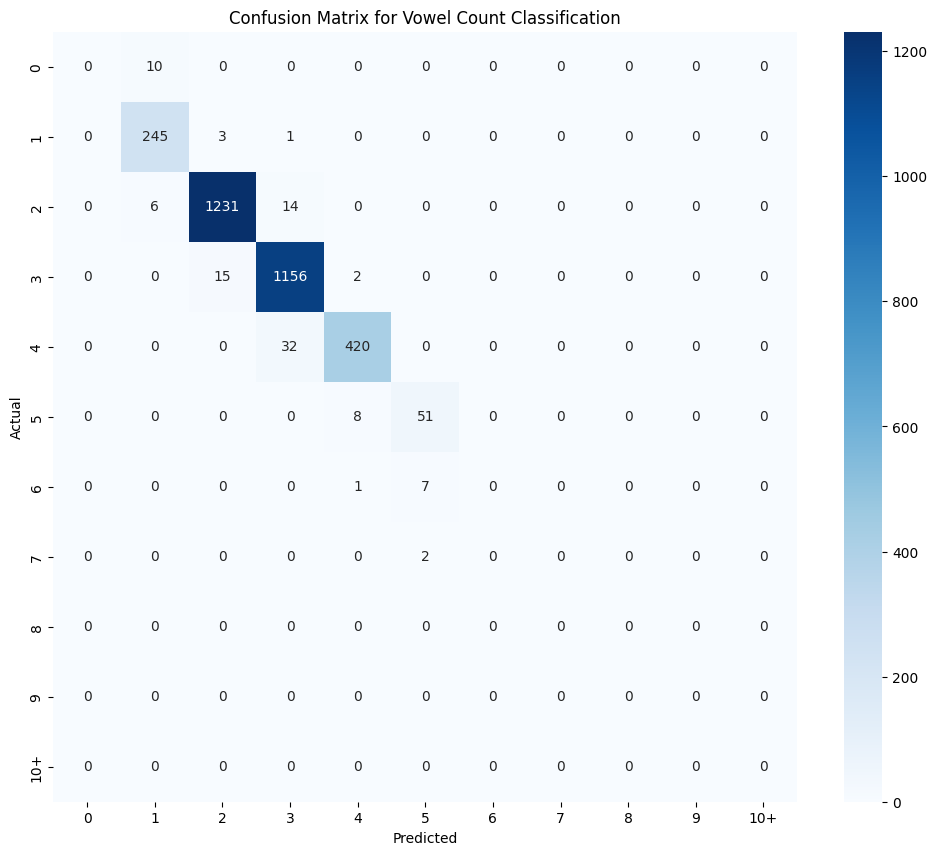

Class 0: 0.000 (10 samples)
Class 1: 0.984 (249 samples)
Class 2: 0.984 (1251 samples)
Class 3: 0.986 (1173 samples)
Class 4: 0.929 (452 samples)
Class 5: 0.864 (59 samples)
Class 6: 0.000 (8 samples)
Class 7: 0.000 (2 samples)


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect predictions and labels
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        logits = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=-1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix with all possible labels (0-10)
cm = confusion_matrix(all_labels, all_predictions, labels=list(range(11)))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) if i < 10 else '10+' for i in range(11)],
            yticklabels=[str(i) if i < 10 else '10+' for i in range(11)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Vowel Count Classification')
plt.show()

# Per-class accuracy
for i in range(11):
    if cm[i].sum() > 0:
        class_acc = cm[i, i] / cm[i].sum()
        print(f"Class {i if i < 10 else '10+'}: {class_acc:.3f} ({cm[i].sum()} samples)")

## Example predictions

In [11]:
def predict_vowel_count(model, name, tokenizer, device):
    """Predict the number of vowels in a name."""
    model.eval()
    
    text = tokenizer.bos_token + name + tokenizer.eos_token
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=32)
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(logits, dim=-1).item()
    
    return prediction

# Test on some examples
test_names = [
    'emma', 'olivia', 'noah', 'william', 'isabella',
    'james', 'charlotte', 'benjamin', 'mia', 'theodore',
    'xyz', 'bcd', 'aeiou', 'rhythm', 'sky'
]

print("Name\t\tActual\tPredicted\tCorrect")
print("="*50)

for name in test_names:
    actual = min(count_vowels(name), 10)
    predicted = predict_vowel_count(model, name, tokenizer, device)
    correct = "✓" if actual == predicted else "✗"
    print(f"{name:12}\t{actual}\t{predicted}\t\t{correct}")

Name		Actual	Predicted	Correct
emma        	2	2		✓
olivia      	4	4		✓
noah        	2	2		✓
william     	3	3		✓
isabella    	4	4		✓
james       	2	2		✓
charlotte   	3	3		✓
benjamin    	3	3		✓
mia         	2	2		✓
theodore    	4	4		✓
xyz         	0	1		✗
bcd         	0	1		✗
aeiou       	5	4		✗
rhythm      	0	1		✗
sky         	0	1		✗


In [12]:
# Find examples where the model made mistakes
model.eval()
errors = []
correct_examples = []

with torch.no_grad():
    for i in range(min(250, len(test_data))):
        name = test_data[i]
        actual = min(count_vowels(name), 10)
        predicted = predict_vowel_count(model, name, tokenizer, device)
        
        if actual != predicted:
            errors.append((name, actual, predicted))
        else:
            correct_examples.append((name, actual))

print(f"Errors: {len(errors)} / 100")
print("\nSome misclassified examples:")
print("Name\t\tActual\tPredicted")
print("="*35)

for name, actual, predicted in errors[:15]:
    print(f"{name:12}\t{actual}\t{predicted}")

Errors: 9 / 100

Some misclassified examples:
Name		Actual	Predicted
anthony     	2	3
million     	3	2
sherly      	1	2
sylvester   	2	3
esequiel    	5	4
aaradhya    	4	3
brynn       	0	1
taliesin    	4	3
aceion      	4	3
